In [61]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from math import sqrt, pi, exp
import scipy.linalg
import time
import matplotlib.pylab as pl
from scipy.sparse.linalg import eigs
import math
import functools
from eki_code.grad_inference import *

In [88]:

K     = np.diag([1,2]) # target e^{-1/2 u K^-1 u}
sqrtK = np.diag([1,sqrt(2)])#  % K^1/2
const = 1.5  # a user-specified const(>1) for the prefactor of convergence
N     = 200   # iteration number 
dt    = 0.05 # step size
d     = 2    # 2D 


In [89]:
# means and covariances along iterations
# for the optimal scheme
MM_opt = np.zeros((2,N))
CC_opt = np.zeros((2,2,N))


# distances to true mean and true covariance along iterations
dis_M_opt  = np.zeros((N,1)) 
dis_C_opt  = np.zeros((N,1))
dis_L2_opt = np.zeros((N,1))



In [145]:
def construct_D_opt_tilde(C,d):
    eigenvalues, eigenvectors = np.linalg.eig(C)
    index_min = np.argmin(eigenvalues)
    lambda_min = eigenvalues[index_min]
    v = eigenvectors[:,index_min]
    D_opt_tilde = (d/lambda_min)*np.tensordot(v,v,axes = 0) # D is symmetric 
    return D_opt_tilde, v, lambda_min

def construct_D_opt(C,d):
    D_opt_tilde, _ , lambda_min = construct_D_opt_tilde(C,d)
    D_opt = D_opt_tilde * lambda_min
    return D_opt

def construct_onb(d,v):
    psis = np.zeros((d,d))
    e_1, e_2 = np.eye(d)[:,0], np.eye(d)[:,1]

    xi = (1/np.sqrt(d))*(e_1+e_2)

    dot_product =  np.dot(v.T, xi) 

    theta =  math.acos(dot_product) 

    c, s = np.cos(theta), np.sin(theta)
    A_theta1 = np.array(((c, -s), (s, c))) 
    A_theta2 = np.array(((c, s), (-s, c)))

    if np.linalg.norm(np.dot(A_theta1,xi)-v)< 1e-8: 
        #print("original theta chosen")
        A_theta = A_theta1
    elif np.linalg.norm(np.dot(A_theta2,xi)-v)< 1e-8:
        #print("had to change theta sign")
        A_theta = A_theta2 
    else:
        print("error wrong angle computed")

    for i in range(0,d): 
        e_parallel = (np.dot(np.eye(d)[:,i],xi) - np.dot(np.eye(d)[:,i],v)*dot_product)/(1-dot_product**2) *xi \
                    +(np.dot(np.eye(d)[:,i],v) - np.dot(np.eye(d)[:,i],xi)*dot_product)/(1-dot_product**2) *v
        psi = np.dot(A_theta,e_parallel) 
        psis[:,i]= psi
    
    return psis


def construct_J_opt_tilde(psis, v, lambda_min, const, d): # works for c>1 
    J_hat = np.zeros((d,d))

    lambda_1 = 1
    lambda_2 = const**2
    lambdas = [lambda_1, lambda_2] 
    
    for j in range(d):
        for k in range(j+1,2): 
            J_hat[j,k] = -((lambdas[j]+lambdas[k])/(lambdas[j]-lambdas[k]))*np.dot(v,psis[:,j])\
                        *np.dot(v,psis[:,k])* (d/lambda_min)
            J_hat[k,j] = - J_hat[j,k]
    J_opt_tilde = functools.reduce(np.dot, [ psis, J_hat, psis.T])
    return J_opt_tilde

def construct_J_opt(psis, v, lambda_min, const, d, sqrtC):
    J_opt_tilde = construct_J_opt_tilde(psis, v, lambda_min, const, d)
    J_opt = functools.reduce(np.dot, [sqrtC, J_opt_tilde, sqrtC])
    return J_opt


# test : we obtain the same values than in Arnold and Signorello section 4.1, good
D_opt_tilde, v, lambda_min = construct_D_opt_tilde(K,d)
print("v")
print(v)
print()
print("lambda_min")
print(lambda_min)
print()
D_opt = construct_D_opt(K,d)
print("D opt")
print(D_opt)
print()


mu = (const**2+1)/(const**2-1) # 2.6 for c=1.5

psis = construct_onb(d,v)
print("psis")
print(psis)
print()

J_opt_tilde = construct_J_opt_tilde(psis, v, lambda_min, const, d) 
print("J opt_tilde")
print(J_opt_tilde)
print()

J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtK) 
print("J opt")
print(J_opt)
print()

C_opt = np.dot(D_opt + J_opt, np.linalg.inv(K))
print("C opt")
print(C_opt)
print()

C_opt_tilde = J_opt_tilde+D_opt_tilde
print("C opt tilde")
print(C_opt_tilde)


v
[1. 0.]

lambda_min
1.0

D opt
[[2. 0.]
 [0. 0.]]

psis
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]

J opt_tilde
[[ 0.   2.6]
 [-2.6  0. ]]

J opt
[[ 0.          3.67695526]
 [-3.67695526  0.        ]]

C opt
[[ 2.          1.83847763]
 [-3.67695526  0.        ]]

C opt tilde
[[ 2.   2.6]
 [-2.6  0. ]]


In [146]:
# for the optimal scheme D opt and J opt are computed from the target matrix covariance K

# initialization

m  = np.asarray([0.2,0.3]).T 
C  = np.diag([2,1])
MM_opt[:,0]   = m
CC_opt[:,:,0] = C

dis_M_opt[0] = np.linalg.norm(m)
dis_C_opt[0] = np.linalg.norm(C-K)

# construct D_opt and J_opt matrices
D_opt_tilde, v, lambda_min = construct_D_opt_tilde(K,d)
D_opt = construct_D_opt(K,d)

psis = construct_onb(d,v)
J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtK) 
    
    
for iter in range(1,N):
    #print(iter)
    m = m - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,m)) # li has a "d - j" below and has a multiplication by C in the end
    C   = C - dt*np.dot((D_opt + J_opt),np.linalg.solve(K,C)) \
                - dt*np.dot(C, np.linalg.solve(K,(D_opt+J_opt).T)) + 2*dt*D_opt
    MM_opt[:,iter]    = m
    CC_opt[:,:,iter]  = C
    #dis_L2[iter] = weighted_L2(m, C, [0,0]', K)
    dis_M_opt[iter] = np.linalg.norm(m)
    dis_C_opt[iter] = np.linalg.norm(C-K)

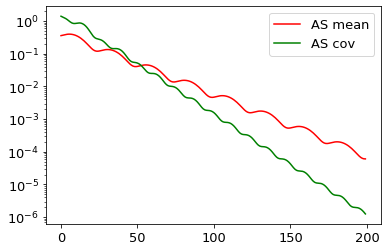

In [153]:
# AS refers to Arnold and Signorello Scheme that uses the true target covariance K for J opt and D opt.

plt.yscale('log',base=10) 
plt.plot(range(0,N), dis_M_opt, c='red', label = 'AS mean')
plt.plot(range(0,N), dis_C_opt, c='green', label = 'AS cov')
plt.legend()

In [ ]:
#  function onb (Algorithm 3) with many tests

def construct_onb(d,v):
    psis = np.zeros((d,d))
    e_1, e_2 = np.eye(d)[:,0], np.eye(d)[:,1]

    xi = (1/np.sqrt(d))*(e_1+e_2)

    dot_product =  np.dot(v.T, xi) 

    theta =  math.acos(dot_product) 

    c, s = np.cos(theta), np.sin(theta)
    A_theta1 = np.array(((c, -s), (s, c))) 
    A_theta2 = np.array(((c, s), (-s, c)))

    if np.linalg.norm(np.dot(A_theta1,xi)-v)< 1e-8: 
        #print("original theta chosen")
        A_theta = A_theta1
    elif np.linalg.norm(np.dot(A_theta2,xi)-v)< 1e-8:
        #print("had to change theta sign")
        A_theta = A_theta2 
    else:
        print("error wrong angle computed")

    #difference = xi - dot_product*v 
    #v_ortho = difference/np.linalg.norm(difference)
    #v_processed = v[np.newaxis,:].T
    #v_ortho_processed = v_ortho[np.newaxis,:].T
    #V = np.concatenate((v_processed,v_ortho_processed), axis = 1) 
    #T = V.dot(A_theta).dot(V.T)

    for i in range(0,d): 
        #e_parallel = np.dot(np.eye(d)[:,i],xi)*xi +np.dot(np.eye(d)[:,i],v)*v
        e_parallel = (np.dot(np.eye(d)[:,i],xi) - np.dot(np.eye(d)[:,i],v)*dot_product)/(1-dot_product**2) *xi \
                    +(np.dot(np.eye(d)[:,i],v) - np.dot(np.eye(d)[:,i],xi)*dot_product)/(1-dot_product**2) *v
        #e_orthogonal = np.eye(d)[:,i] - e_parallel
        psi = np.dot(A_theta,e_parallel) 
        psis[:,i]= psi
        
    # test 1
    #print("test 1 : if Txi = v")
    #print(np.all(np.isclose(np.dot(T,xi), v)))

    # test 2
    #print("test 2: orthonormality of psis")
    #print(np.all(np.isclose(np.dot(psis,psis.T), np.eye(d))))

    
    # print("test 3 : if <psi_k, Dopt_tilde psi_k> = Tr(D_opt_tilde)/d")
    #for i in range(0,d):
    #    print("test trace")
    #    a = np.dot(v,psis[:,i])*np.dot(v,psis[:,i])*(d/lambda_min)
    #    print(a)
    #    b = np.trace(D_opt_tilde)/d
    #    print(b)
    #    print(np.all(np.isclose(a,b)))
        
    # test 4 ("test 4: psis orthogonal")
    #print("test 4")
    #print(np.dot(psis[:,0],psis[:,1]))
    
    # test 5
    #print("test 4")
    #print(np.dot(psis,psis.T))
    
    return psis


In [ ]:
# old function construct_onb with matrix V (keep this part for d>2, see mail exchange with Li Wang)

"""
def construct_onb(d,v):
    psis = np.zeros((d,d))
    e_1, e_2 = np.eye(d)[:,0], np.eye(d)[:,1]
    
    xi = (1/np.sqrt(d))*(e_1+e_2)
    
    dot_product =  np.dot(v.T, xi) 
    theta =  math.acos(dot_product) 
    
    c, s = np.cos(theta), np.sin(theta)
    A_theta1 = np.array(((c, -s), (s, c))) 
    A_theta2 = np.array(((c, s), (-s, c)))

    if np.linalg.norm(np.dot(A_theta1,xi)-v)< 1e-8: # ici c'est reverse par rapport à Li
        A_theta = A_theta1
    elif np.linalg.norm(np.dot(A_theta2,xi)-v)< 1e-8:
        A_theta = A_theta2 
    else:
        print("error wrong angle computed")
    
    difference = xi - dot_product*v 
    v_prime = difference/np.linalg.norm(difference)
    v_processed = v[np.newaxis,:].T
    v_prime_processed = v_prime[np.newaxis,:].T
    V = np.concatenate((v_processed,v_prime_processed), axis = 1) 

    T = V.dot(A_theta).dot(V.T)
    
    # test 1
    print("test of Txi = v")
    print(np.all(np.isclose(np.dot(T,xi), v)))
    
    for i in range(0,d): # J'ai pas de "eta" comme dans le code de Li
        e_parallel = np.dot(np.eye(d)[:,i],xi)*xi +np.dot(np.eye(d)[:,i],v)*v
        e_orthogonal = np.eye(d)[:,i] - e_parallel
        psi = np.dot(T,e_parallel) + e_orthogonal # Difference : Li uses A instead of T
        psis[:,i]= psi
        
    # test 2
    print("test orthonormality of psis")
    print(np.all(np.isclose(np.dot(psis,psis.T), np.eye(d))))
    
    # test 3 
    for i in range(0,d):
        np.dot(v,psis[:,i])*np.dot(v,psis[:,i])
        
    return psis
"""
